In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train = pd.read_csv('train_50_50.csv')
train.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,1,2,1,0,0,1,1,1,0,1,0,2,0,1,0,0,13,5,5
1,2,0,1,1,4,0,0,0,1,0,1,0,1,0,1,0,0,0,0,9,5,8
2,0,0,1,1,3,0,0,0,1,1,1,0,1,0,4,5,3,0,1,2,6,7
3,0,0,0,1,3,1,0,0,1,1,1,0,1,0,2,0,2,0,1,9,5,2
4,2,0,0,1,2,0,1,0,1,0,1,0,1,0,5,0,30,1,1,10,6,5


In [ ]:
train['Diabetes_012'].replace(2, 1, inplace=True)

In [ ]:
set(np.asarray(train['Diabetes_012']))

{0, 1}

In [ ]:
train.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,0,0,1,2,1,0,0,1,1,1,0,1,0,2,0,1,0,0,13,5,5
1,1,0,1,1,4,0,0,0,1,0,1,0,1,0,1,0,0,0,0,9,5,8
2,0,0,1,1,3,0,0,0,1,1,1,0,1,0,4,5,3,0,1,2,6,7
3,0,0,0,1,3,1,0,0,1,1,1,0,1,0,2,0,2,0,1,9,5,2
4,1,0,0,1,2,0,1,0,1,0,1,0,1,0,5,0,30,1,1,10,6,5


In [ ]:
test = pd.read_csv('test_BMI_processed.csv')
test.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,3,1,0,0,1,1,1,0,1,0,3,5,15,0,1,13,4,6
1,1,0,0,1,3,0,0,0,1,1,1,0,1,0,3,5,10,0,1,10,5,5
2,2,0,0,1,4,0,0,0,1,0,1,0,1,0,2,0,0,0,0,13,4,5
3,0,1,1,1,3,0,1,1,1,1,1,0,1,0,4,0,1,1,1,9,4,3
4,0,0,0,1,5,1,0,0,1,0,1,0,1,0,2,0,0,0,1,7,6,8


In [ ]:
test['Diabetes_012'].replace(2, 1, inplace=True)

In [ ]:
set(np.asarray(test['Diabetes_012']))

{0, 1}

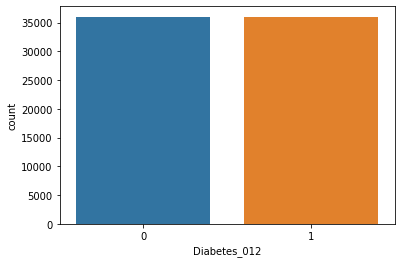

In [ ]:
sns.countplot(x = 'Diabetes_012', data=train)

In [ ]:
test.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,3,1,0,0,1,1,1,0,1,0,3,5,15,0,1,13,4,6
1,1,0,0,1,3,0,0,0,1,1,1,0,1,0,3,5,10,0,1,10,5,5
2,1,0,0,1,4,0,0,0,1,0,1,0,1,0,2,0,0,0,0,13,4,5
3,0,1,1,1,3,0,1,1,1,1,1,0,1,0,4,0,1,1,1,9,4,3
4,0,0,0,1,5,1,0,0,1,0,1,0,1,0,2,0,0,0,1,7,6,8


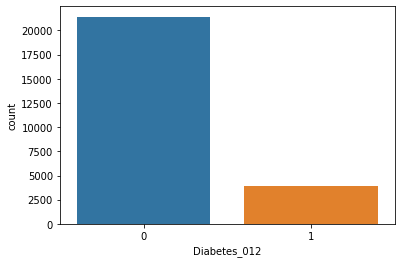

In [ ]:
sns.countplot(x = 'Diabetes_012', data=test)

In [ ]:
X = train.iloc[:, 1:]
y = train.iloc[:, 0]

In [ ]:
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

In [ ]:
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=32)

In [ ]:
X_train.shape,X_val.shape, X_test.shape

((64832, 21), (7204, 21), (25368, 21))

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
#hyperparameter tuning
epochs = 30
batch_size = 50
learning_rate = 0.00006
num_features = len(X.columns)
num_classes = len(set(y))

In [ ]:
#initializing dataloader for train, val and test data
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
)
val_loader = DataLoader(dataset=val_dataset, batch_size= 1) #len(X_val)
test_loader = DataLoader(dataset=test_dataset, batch_size=1) #len(X_test)

In [ ]:
# test1- 12,8,6
# test2 - 16,8,4
# test3 - 32,16,4


In [ ]:
#defining our neural net
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 8 )
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, num_classes)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.5)
        #self.batchnorm1 = nn.BatchNorm1d(64)
        #self.batchnorm2 = nn.BatchNorm1d(32)
        #self.batchnorm3 = nn.BatchNorm1d(8)

    def forward(self, x):
        out = self.fc1(x)
        #out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        #out = self.batchnorm2(out)
        out = self.relu(out)
        #out = self.dropout(out)
        
        out = self.fc3(out)
        #out = self.batchnorm3(out)
        out = self.relu(out)
        #out = self.dropout(out)
        
        out = self.fc4(out)

        return out
        

In [ ]:
model = Net(num_features = num_features, num_classes = num_classes)
print(model)

Net(
  (fc1): Linear(in_features=21, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
model.to(device)

Net(
  (fc1): Linear(in_features=21, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def calculate_accuracy(y_pred, y_test):
    #perform log_softmax on y_pred
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    #choose the class with highest probability
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    #count the number of correct predictions
    correct_pred = 0
    for i in range(len(y_test)):
      if y_pred_tags[i] == y_test[i]:
        correct_pred += 1
    

    #correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred / len(y_pred)
    
    acc = acc * 100
    
    return acc

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
train_loader_len = len(train_loader)
val_loader_len = len(val_loader)

for e in tqdm(range(1, epochs+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model.forward(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = calculate_accuracy(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc
  
    with torch.no_grad():
      val_epoch_loss = 0
      val_epoch_acc = 0
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        
        y_val_pred = model.forward(X_val_batch)
                    
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = calculate_accuracy(y_val_pred, y_val_batch)
        
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc
        
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

    train_loss_list.append(train_epoch_loss/train_loader_len)
    train_acc_list.append(train_epoch_acc/train_loader_len)
    val_loss_list.append(val_epoch_loss/val_loader_len)
    val_acc_list.append(val_epoch_acc/val_loader_len)
 


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.66777 | Val Loss: 0.63971 | Train Acc: 61.177| Val Acc: 68.406
Epoch 002: | Train Loss: 0.61280 | Val Loss: 0.58320 | Train Acc: 69.640| Val Acc: 70.947
Epoch 003: | Train Loss: 0.56867 | Val Loss: 0.55565 | Train Acc: 71.300| Val Acc: 72.210
Epoch 004: | Train Loss: 0.55098 | Val Loss: 0.54565 | Train Acc: 72.049| Val Acc: 72.432
Epoch 005: | Train Loss: 0.54354 | Val Loss: 0.54086 | Train Acc: 72.519| Val Acc: 72.737
Epoch 006: | Train Loss: 0.53933 | Val Loss: 0.53796 | Train Acc: 72.872| Val Acc: 72.890
Epoch 007: | Train Loss: 0.53637 | Val Loss: 0.53577 | Train Acc: 73.081| Val Acc: 73.168
Epoch 008: | Train Loss: 0.53407 | Val Loss: 0.53402 | Train Acc: 73.195| Val Acc: 73.168
Epoch 009: | Train Loss: 0.53228 | Val Loss: 0.53259 | Train Acc: 73.310| Val Acc: 73.334
Epoch 010: | Train Loss: 0.53076 | Val Loss: 0.53138 | Train Acc: 73.384| Val Acc: 73.431
Epoch 011: | Train Loss: 0.52949 | Val Loss: 0.53043 | Train Acc: 73.504| Val Acc: 73.626
Epoch 012:

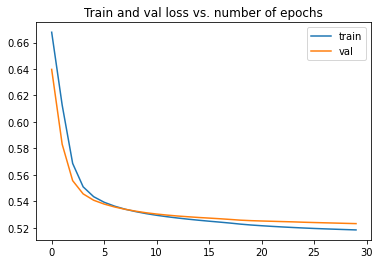

In [ ]:
plt.title("Train and val loss vs. number of epochs")
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','val'])
plt.show()


In [ ]:
torch.save(model, "model.pth")
torch.save(model.state_dict(), "model_weights.pth")

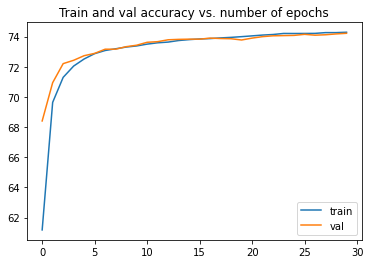

In [ ]:
plt.title("Train and val accuracy vs. number of epochs")
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.legend(['train','val'])
plt.show()

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model.forward(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
set(np.asarray(y_test))

{0, 1}

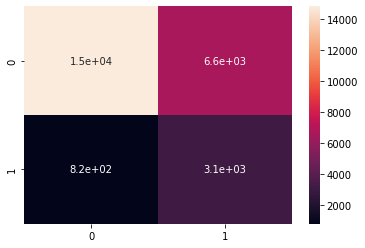

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns={0:0,1:1}, index={0:0,1:1})

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     21409
           1       0.32      0.79      0.46      3959

    accuracy                           0.71     25368
   macro avg       0.63      0.74      0.63     25368
weighted avg       0.85      0.71      0.75     25368

